In [1]:
from PIL import Image #importing the python image library for PIL
import os,cv2
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy import misc 
from scipy.misc import imresize
from scipy.misc import imread

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

from sklearn.metrics import confusion_matrix

import tensorflow.keras
from tensorflow.python.keras import utils
from tensorflow.python.keras.utils import np_utils
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.python.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D,InputLayer

In [2]:
# Setting the directory path and loading the data from the train and test files
root_dir = os.path.abspath('.')
data_dir_test = './datasets/misctest'
data_dir = './datasets/misctrain'
train = pd.read_csv(os.path.join(data_dir, 'train.csv'))
test = pd.read_csv(os.path.join(data_dir_test, 'test.csv'))

In [18]:
#setting X(feature) and y(target) variables
X  = train.drop(columns ='Class' )
y = train.Class

In [20]:
lb = LabelEncoder()
y = lb.fit_transform(train.Class)
y = np_utils.to_categorical(y)

In [21]:
#performing train_test_split
X_train,X_test,y_train,y_test = train_test_split(X,y,random_state=42,stratify=y)

In [22]:
X_train.shape

(14929, 1)

In [23]:
X_test.shape

(4977, 1)

In [24]:

temp = []
for img_name in X_train.ID:
    img_path = os.path.join(data_dir, 'Train', img_name)
    img = imread(img_path,mode='L')
    img = imresize(img, (64, 64))
    img = img.astype('float32') # this will help us in later stage
    temp.append(img)

X_train = np.stack(temp)

/Users/payalchodha/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  import sys
/Users/payalchodha/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  


In [25]:
X_train.shape

(14929, 64, 64)

In [26]:

temp = []
for img_name in X_test.ID:
    img_path = os.path.join(data_dir, 'Train', img_name)
    img = imread(img_path,mode='L')
    img = imresize(img, (64, 64))
    img = img.astype('float32') # this will help us in later stage
    temp.append(img)

X_test = np.stack(temp)


/Users/payalchodha/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  import sys
/Users/payalchodha/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  


In [27]:
X_train = X_train / 255
X_test = X_test/255

In [29]:
X_train= X_train.reshape(X_train.shape[0],64,64,1)
X_test= X_test.reshape(X_test.shape[0],64,64,1)

In [187]:
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images


datagen.fit(X_train)

In [43]:
input_num_units = (64, 64, 1)
hidden_num_units = 500
output_num_units = 3

epochs =10
batch_size = 128

In [44]:
# Instantiate a CNN.
cnn_model = Sequential()

In [45]:
# Add a convolutional layer.

cnn_model.add( Conv2D(filters = 32, # number of filters
               kernel_size = (3,3),# height/width of filter
               activation='relu', # activation function 
              input_shape=(64,64,1))) # shape of input (image)
cnn_model.add(MaxPooling2D(pool_size = (2, 2))) # dimensions of region of pooling # dimensions of region of pooling
cnn_model.add(Dropout(rate=0.5))
cnn_model.add(Conv2D(filters = 64,
                     kernel_size=(3,3),
                     activation='relu')) 

cnn_model.add(MaxPooling2D(pool_size=(2,2)))
cnn_model.add(Dropout(rate=0.5))
cnn_model.add(Flatten())
# Add a densely-connected layer with 128 neurons.
cnn_model.add(Dense(512,activation='relu'))
cnn_model.add(Dropout(rate=0.5))
cnn_model.add(Dense(128,activation='relu'))
cnn_model.add(Dropout(rate=0.5))
# Add a final layer with 3 neurons.
cnn_model.add(Dense(3,activation='softmax'))

In [48]:
#defining Earlystopping variable
early_stop = EarlyStopping(monitor = 'val_loss',
                          min_delta = 0, #if it ticks up by a little bit(i consider it as an increase)
                          patience = 3) #number of epochs with no improvement after which training will be stopped

In [49]:
# Compile model
cnn_model.compile(loss='categorical_crossentropy',
                  optimizer=Adam(lr=0.001),
                  metrics=['accuracy'])

In [50]:
#defining ReduceLROnPlateau variable
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

In [51]:
X_train.shape

(14929, 64, 64, 1)

In [52]:
X_test.shape

(4977, 64, 64, 1)

In [122]:
# history = cnn_model.fit_generator(datagen.flow(train_x,y_train, batch_size=batch_size),
                              epochs = epochs, validation_data = (test_x,y_test),
                              verbose = 1, steps_per_epoch=train_x.shape[0] // batch_size
                              , callbacks=[learning_rate_reduction])


In [53]:
#fixing the class weights for the unbalanced classes
from sklearn.utils import class_weight

y_ints = [y.argmax() for y in y_train]



class_weights = class_weight.compute_class_weight('balanced',
                                                 np.unique(y_ints),
                                                 y_ints)

class_weight_dict = dict(enumerate(class_weights))


In [54]:
class_weight_dict

{0: 0.6141346826278333, 1: 2.76924503802634, 2: 0.9895274077019951}

In [55]:
#fitting CNN model with regualarization and class-weight
history_cnn = cnn_model.fit(X_train,y_train,epochs = epochs, validation_data = (X_test,y_test),class_weight=class_weights,
                              verbose = 1, batch_size= batch_size
                              , callbacks=[early_stop,learning_rate_reduction])

Train on 14929 samples, validate on 4977 samples
Epoch 1/10
14929/14929 [==============================] - 95s 6ms/sample - loss: 0.9472 - accuracy: 0.5434 - val_loss: 0.9011 - val_accuracy: 0.6078
Epoch 2/10
14929/14929 [==============================] - 84s 6ms/sample - loss: 0.8430 - accuracy: 0.6120 - val_loss: 0.8680 - val_accuracy: 0.6156
Epoch 3/10
14929/14929 [==============================] - 79s 5ms/sample - loss: 0.8028 - accuracy: 0.6356 - val_loss: 0.8001 - val_accuracy: 0.6526
Epoch 4/10
14929/14929 [==============================] - 94s 6ms/sample - loss: 0.7755 - accuracy: 0.6511 - val_loss: 0.7940 - val_accuracy: 0.6534
Epoch 5/10
14929/14929 [==============================] - 81s 5ms/sample - loss: 0.7479 - accuracy: 0.6691 - val_loss: 0.7468 - val_accuracy: 0.6703
Epoch 6/10
14929/14929 [==============================] - 74s 5ms/sample - loss: 0.7300 - accuracy: 0.6766 - val_loss: 0.7423 - val_accuracy: 0.6817
Epoch 7/10
14929/14929 [==============================] -

In [137]:
#fitting CNN model with regualarization,class-weight and datagenerator
history_weight = cnn_model.fit_generator(datagen.flow(X_train,y_train, batch_size=batch_size),
                              epochs = epochs, validation_data = (X_test,y_test),class_weight=class_weights,
                              verbose = 1, steps_per_epoch=X_train.shape[0] // batch_size
                              , callbacks=[early_stop])


Epoch 1/30
116/116 [==============================] - 116s 1s/step - loss: 0.9987 - accuracy: 0.5232 - val_loss: 1.0321 - val_accuracy: 0.5427
Epoch 2/30
116/116 [==============================] - 89s 771ms/step - loss: 0.9364 - accuracy: 0.5446 - val_loss: 0.9557 - val_accuracy: 0.5435
Epoch 3/30
116/116 [==============================] - 112s 965ms/step - loss: 0.8849 - accuracy: 0.5812 - val_loss: 0.8997 - val_accuracy: 0.5891
Epoch 4/30
116/116 [==============================] - 107s 922ms/step - loss: 0.8636 - accuracy: 0.5945 - val_loss: 0.8350 - val_accuracy: 0.6178
Epoch 5/30
116/116 [==============================] - 88s 754ms/step - loss: 0.8483 - accuracy: 0.6090 - val_loss: 0.8139 - val_accuracy: 0.6315
Epoch 6/30
116/116 [==============================] - 112s 965ms/step - loss: 0.8313 - accuracy: 0.6137 - val_loss: 0.7951 - val_accuracy: 0.6335
Epoch 7/30
116/116 [==============================] - 107s 921ms/step - loss: 0.8270 - accuracy: 0.6228 - val_loss: 0.8009 - val_

In [56]:
# from scipy.misc import imresize
# from scipy.misc import imread

temp = []
for img_name in test.ID:
    img_path = os.path.join(data_dir_test, 'Test', img_name)
    img = imread(img_path,mode='L')
    img = imresize(img, (64, 64))
    img = img.astype('float32') # this will help us in later stage
    img = img/255
    
    temp.append(img)

test_x = np.stack(temp)


/Users/payalchodha/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  import sys
/Users/payalchodha/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  


In [57]:
test_x = test_x.reshape(test_x.shape[0],64,64,1)

In [58]:
test_x.shape

(6636, 64, 64, 1)

/Users/payalchodha/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  after removing the cwd from sys.path.
/Users/payalchodha/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  """


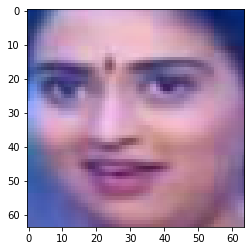

Predicted: YOUNG


In [59]:
i = random.choice(test.index)
img_name = test.ID[i]

img = imread(os.path.join(data_dir_test, 'Test', img_name)).astype('float32')
img =imresize(img, (64, 64))
imgplot = plt.imshow(img)
plt.show()
# //imshow(imresize(img, (128, 128)))
pred = cnn_model.predict_classes(test_x)
pred = lb.inverse_transform(pred)
print(f'Predicted: {pred[i]}')


In [60]:
X_test.shape

(4977, 64, 64, 1)

In [217]:
y_test

array([[1., 0., 0.],
       [1., 0., 0.],
       [0., 0., 1.],
       ...,
       [1., 0., 0.],
       [0., 0., 1.],
       [0., 0., 1.]], dtype=float32)

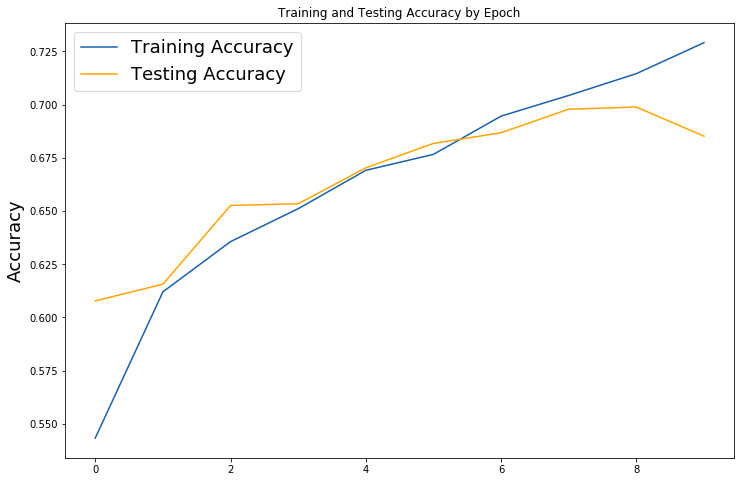

In [61]:
#plotting the training and test accuracy 
train_acc = history_cnn.history['accuracy']
test_acc = history_cnn.history['val_accuracy']

# Set figure size.
plt.figure(figsize=(12, 8))

# Generate line plot of training, testing loss over epochs.
plt.plot(train_acc, label='Training Accuracy', color='#185fad')
plt.plot(test_acc, label='Testing Accuracy', color='orange')

# Set title
plt.title('Training and Testing Accuracy by Epoch')
plt.ylabel('Accuracy', fontsize = 18)
#plt.xticks([0, 1, 2, 3, 4], [1, 2, 3, 4, 5])

plt.legend(fontsize = 18);

In [68]:
#saving the model for FLASK
# note: you can't pickl a keras model 
cnn_model.save('./cnn_model.h5')

In [64]:
# Evaluate model on test data.
cnn_score = cnn_model.evaluate(X_test,
                               y_test,
                               verbose=0)

cnn_labels = cnn_model.metrics_names

In [65]:
cnn_score[1]

0.6851517

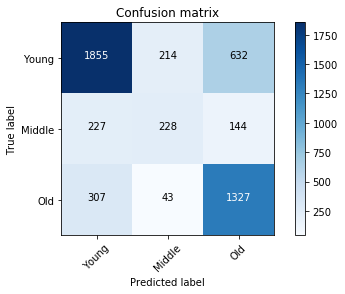

In [73]:
# Look at confusion matrix 

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Predict the values from the validation dataset
Y_pred = cnn_model.predict(X_test)
# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(Y_pred,axis = 1) 
# Convert validation observations to one hot vectors
Y_true = np.argmax(y_test,axis = 1) 
# compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes = ['Young','Middle','Old']) 


In [74]:
Y_pred.shape

(4977, 3)

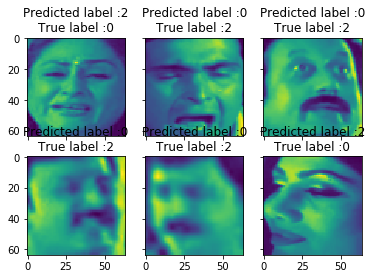

In [75]:
# Display some error results 

# Errors are difference between predicted labels and true labels
errors = (Y_pred_classes - Y_true != 0)

Y_pred_classes_errors = Y_pred_classes[errors]
Y_pred_errors = Y_pred[errors]
Y_true_errors = Y_true[errors]
X_test_errors = X_test[errors]

def display_errors(errors_index,img_errors,pred_errors, obs_errors):
    """ This function shows 6 images with their predicted and real labels"""
    n = 0
    nrows = 2
    ncols = 3
    fig, ax = plt.subplots(nrows,ncols,sharex=True,sharey=True)
    for row in range(nrows):
        for col in range(ncols):
            error = errors_index[n]
            ax[row,col].imshow((img_errors[error]).reshape((64,64)))
            ax[row,col].set_title("Predicted label :{}\nTrue label :{}".format(pred_errors[error],obs_errors[error]))
            n += 1

# Probabilities of the wrong predicted numbers
Y_pred_errors_prob = np.max(Y_pred_errors,axis = 1)

# Predicted probabilities of the true values in the error set
true_prob_errors = np.diagonal(np.take(Y_pred_errors, Y_true_errors, axis=1))

# Difference between the probability of the predicted label and the true label
delta_pred_true_errors = Y_pred_errors_prob - true_prob_errors

# Sorted list of the delta prob errors
sorted_dela_errors = np.argsort(delta_pred_true_errors)

# Top 6 errors 
most_important_errors = sorted_dela_errors[-6:]

# Show the top 6 errors
display_errors(most_important_errors, X_test_errors, Y_pred_classes_errors, Y_true_errors)